Importing

In [1]:
import torch
from torch.optim import Adamax
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

Function to Model

In [2]:
#f
def f(x):
    y = -5*x**3 + x**2 + x + 2
    return y

#f'
def f_1(x):
    y = -15*x**2 + 2*x + 1
    return y

#f''
def f_2(x):
    y = -30*x + 2
    return y


Sampling a vector from defined function

In [3]:
# number of vectors
num = 8
# length of vectors
len = 10
# x values from uniform random distribution between -5 and 5
X_sample = np.random.rand(num,len)*10 - 5

Y_sample =  f(X_sample)

X_sample = torch.from_numpy(X_sample).float()
Y_sample = torch.from_numpy(Y_sample).float()


Defining the Model, Loss and Optimizer

In [4]:
# len i/o nodes, i_len nodes per layer and ELU activation fn
i_len = 30
# number of parameters to approximate
params = 1

model = nn.Sequential(
    nn.Linear(params, i_len),
    nn.ELU(),
    nn.Linear(i_len, i_len),
    nn.ELU(),
    nn.Linear(i_len, i_len),
    nn.ELU(),
    nn.Linear(i_len, params)
    )

# mean squared error as loss fn
loss_fn = nn.MSELoss()

# choose optimizer
optim = Adamax(model.parameters())

Graphing model accuracy

In [5]:
# plot function over lower (l) to upper (u), with title (t), with bool (s) to display samples.
def plot(l,u,t,s):
    n_step = 1000

    X_plot = np.linspace(l,u,n_step)
    Y_plot = f(X_plot)

    # creating x values to test and y values for loss
    X_temp = torch.from_numpy(X_plot).float().view(-1,1)
    Y_temp = torch.from_numpy(Y_plot).float().view(-1,1)

    Y_preds = model(X_temp)
    Y_pred_plot = torch.reshape(Y_preds, (-1,)).detach().numpy()

    loss_plot = loss_fn(Y_preds, Y_temp)
    
    if s:
        # reshaping samples for plot
        X_sample_plot = np.reshape(X_sample, (1,-1))
        Y_sample_plot = np.reshape(Y_sample, (1,-1))
        
        plt.plot(X_plot, Y_plot, X_plot, Y_pred_plot, X_sample_plot, Y_sample_plot, 'go',markersize=3)
        plt.legend(['Function to Model','MLP Approximation','Samples'])
    else:
        plt.plot(X_plot, Y_plot, X_plot, Y_pred_plot)
        plt.legend(['Function to Model','MLP Approximation'])

    title = t + f"Epoch {epoch}, Loss {loss_plot:.2E}"
    plt.title(title)
    plt.show()
    plt.clf()

Training the Model

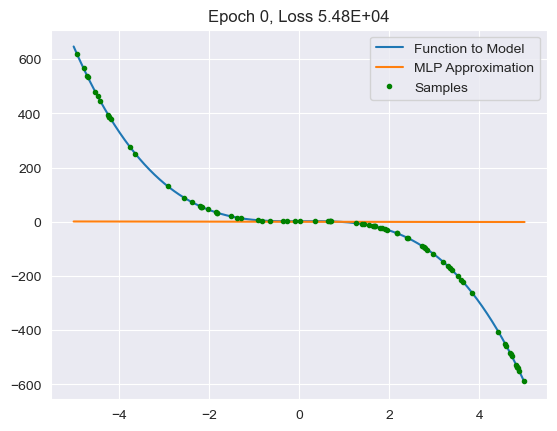

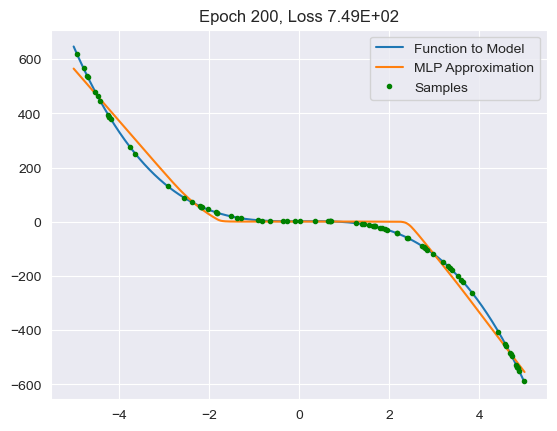

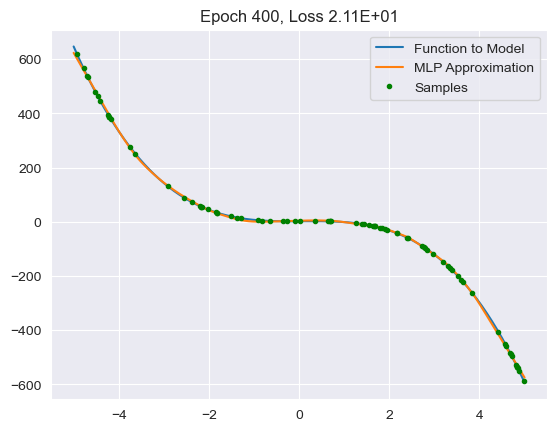

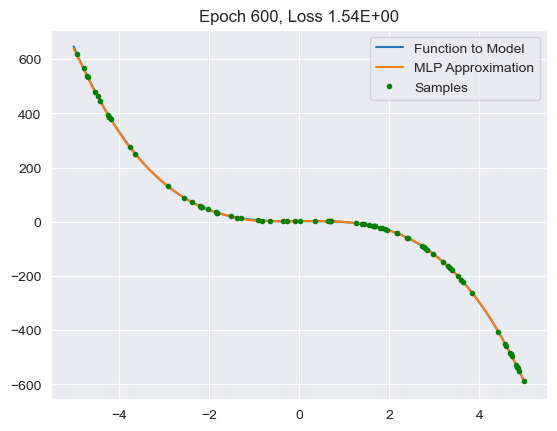

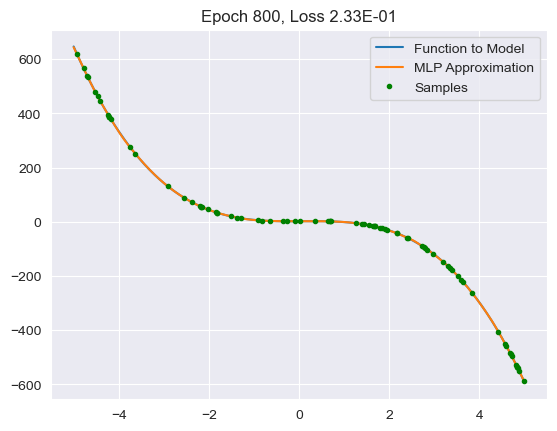

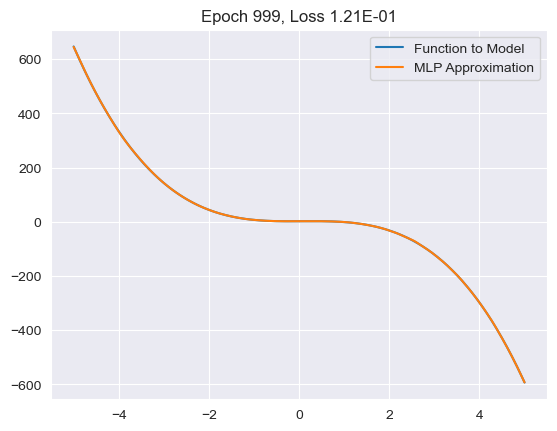

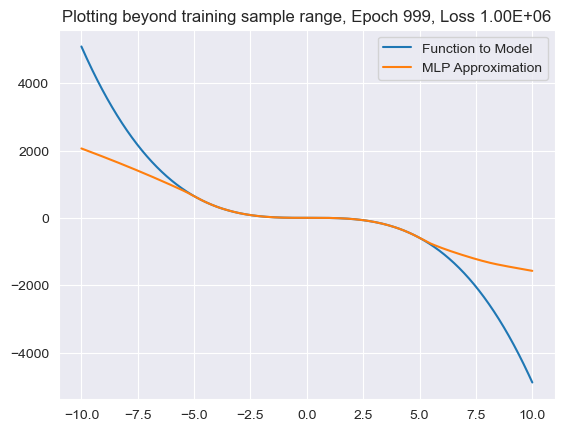

<Figure size 640x480 with 0 Axes>

In [6]:
n_epochs = 1000
# number of batches = num, length of batch = len

for epoch in range(n_epochs):
    for batch in range(num):
        y_pred = model(X_sample[batch,:].view(-1,1))
        loss = loss_fn(y_pred, Y_sample[batch,:].view(-1,1))
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    if not (epoch%200):
        plot(-5,5,'',1)
    #print(f'Finished epoch {epoch}, latest loss {loss}')

plot(-5,5,'',0)
plot(-10,10,'Plotting beyond training sample range, ',0)

Plotting first derivative using autograd

In [7]:
def plot_f1(l,u,t):
    n_step = 1000

    X_plot = np.linspace(l,u,n_step)
    Y_plot = f_1(X_plot)

    # to obtain grads, requires_grad must be set to true
    X_temp = torch.linspace(l, u, steps=n_step, requires_grad=True).view(-1,1)
    Y_temp = torch.from_numpy(Y_plot).float().view(-1,1)

    # change y preds to deriv
    Y_preds = model(X_temp)
    Y_pred_plot = torch.reshape(Y_preds, (-1,)).detach().numpy()

    # differentiate output w.r.t. input, to grad_output order. Retaining graph allows the graph to be stored and not recalculated to be used subsequently.
    grads = torch.autograd.grad(outputs=Y_preds, inputs=X_temp, grad_outputs=torch.ones_like(Y_preds))[0]
    grad_plot = torch.reshape(grads, (-1,)).detach().numpy()

    loss_plot = loss_fn(grads, Y_temp)
    
    plt.plot(X_plot, Y_plot, X_plot, grad_plot)
    title = t + f"Epoch {epoch}, Loss {loss_plot:.2E}"
    plt.title(title)
    plt.legend(['Function to Model','MLP Approximation'])
    plt.show()
    plt.clf()

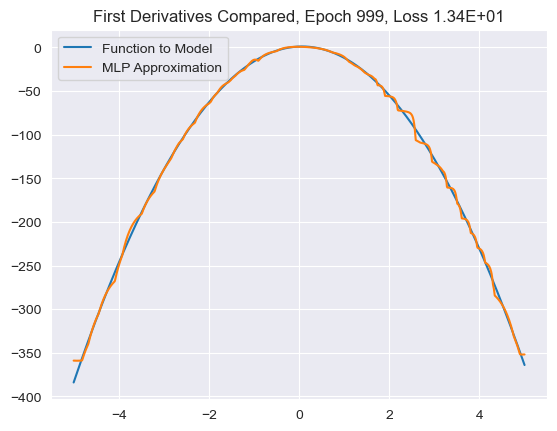

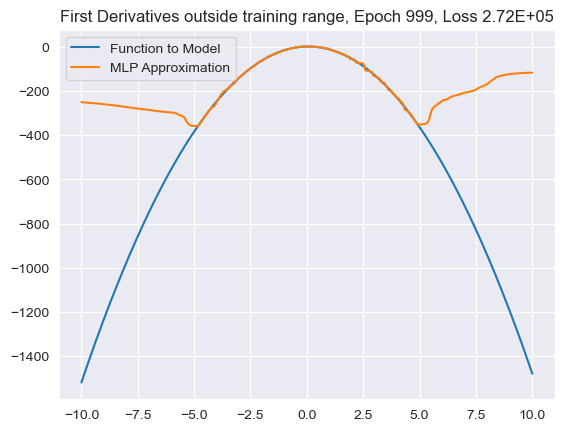

<Figure size 640x480 with 0 Axes>

In [8]:
plot_f1(-5,5,'First Derivatives Compared, ')
plot_f1(-10,10,'First Derivatives outside training range, ')

Plotting second derivative using autograd

In [9]:
def plot_f2(l,u,t):
    n_step = 1000

    X_plot = np.linspace(l,u,n_step)
    Y_plot = f_2(X_plot)

    # to obtain grads, requires_grad must be set to true
    X_temp = torch.linspace(l, u, steps=n_step, requires_grad=True).view(-1,1)
    Y_temp = torch.from_numpy(Y_plot).float().view(-1,1)

    # change y preds to deriv
    Y_preds = model(X_temp)
    Y_pred_plot = torch.reshape(Y_preds, (-1,)).detach().numpy()

    # differentiate output w.r.t. input, to grad_output order. Retaining graph allows the graph to be stored and not recalculated to be used subsequently.
    first_deriv = torch.autograd.grad(outputs=Y_preds, inputs=X_temp, grad_outputs=torch.ones_like(Y_preds), create_graph=True)[0]
    second_deriv = torch.autograd.grad(outputs=first_deriv, inputs=X_temp, grad_outputs=torch.ones_like(Y_preds))[0]
    grad_plot = torch.reshape(second_deriv, (-1,)).detach().numpy()

    loss_plot = loss_fn(second_deriv, Y_temp)
    
    plt.plot(X_plot, Y_plot, X_plot, grad_plot)
    title = t + f"Epoch {epoch}, Loss {loss_plot:.2E}"
    plt.title(title)
    plt.legend(['Function to Model','MLP Approximation'])
    plt.show()
    plt.clf()

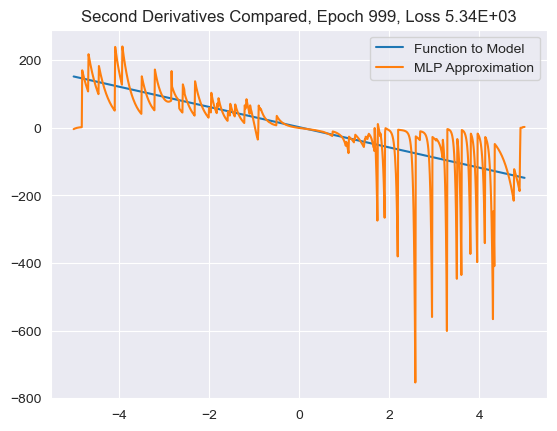

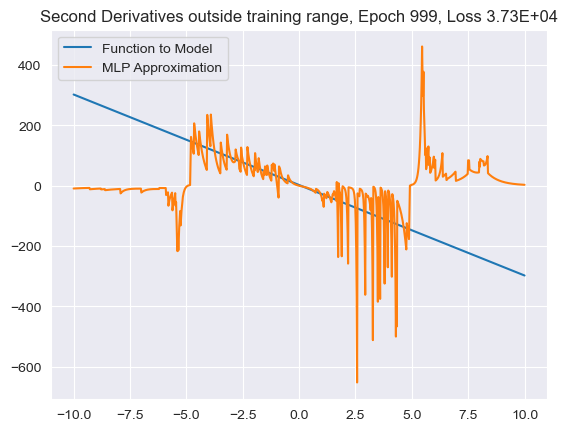

<Figure size 640x480 with 0 Axes>

In [10]:
plot_f2(-5,5,'Second Derivatives Compared, ')
plot_f2(-10,10,'Second Derivatives outside training range, ')